In [1]:
import os
import sys
import pandas as pd
import datetime

import pathlib
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import importlib


from tensorflow.keras import layers, losses
from tensorflow.keras.models import Model
from tensorflow import keras
from tensorflow.keras import callbacks  

# project specific
sys.path.append('../src')
from utils import data_handler
from utils import benchmark
from utils import visualisation
from utils.models import vanilla_autoencoder


import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow.python.ops.numpy_ops import np_config
np_config.enable_numpy_behavior()

import plotly.express as px
import plotly.subplots as sp
import plotly.graph_objs as go

pd.options.display.width = 1000


absolute_path = "c:/thesis/data/cancer"


%load_ext tensorboard
!rm -rf ../workfiles/logs/

## Experiment 

loading samples...
loaded 2259 / 2259 samples
selecting genes based on median absolute deviation threshold:  2 ...
min MAD 0.0
max MAD 285733.0


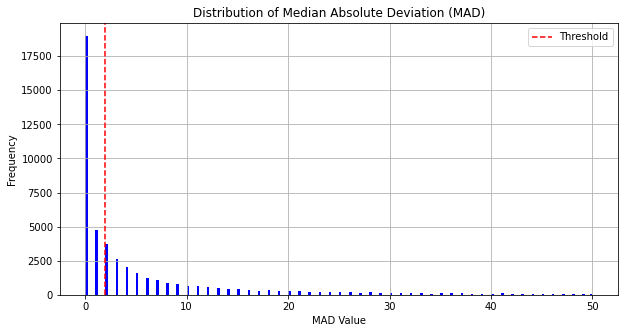

removing 39580 genes under the MAD threshold from the dataset
number of genes selected :  21080
number of genes selected :  21080
log(1 + x) transformation...
scaling to [0, 1]...
shape of the dataset : (2259, 21080)
number of seq in the dataset : 2259


In [2]:
# experiment 1
x_train, filenames, n_genes, gene_names = data_handler.generate_dataset_cancer(
    #path = absolute_path,
    feature_selection_threshold = 2)

In [6]:
# adding my own labels :

filenames_ = [fn.split("/")[-1] for fn in filenames]

import json
from tqdm import tqdm

with open("c:/thesis/data/cancer/metadata.cart.2023-09-11.json", 'r') as metadata_file:
    metadata = json.load(metadata_file)

# Read clinical data from TSV file
clinical = pd.read_csv("c:/thesis/data/cancer/clinical.cart.2023-09-11/clinical.tsv", sep='\t')


def get_clinical_info(given_filename):
    matching_index = None

    # Loop through metadata to find a match
    for i, item in enumerate(metadata):
        if item["file_name"] == given_filename:
            matching_index = i
            break
    
    case_id = metadata[matching_index]["associated_entities"][0]["case_id"]
    return clinical[clinical["case_id"] == case_id]["tissue_or_organ_of_origin"].values[0]

clinical_info = [get_clinical_info(filename) for filename in tqdm(filenames_)]
clinical_info[0:5]


100%|██████████| 2259/2259 [00:00<00:00, 2367.53it/s]


['Corpus uteri', 'Kidney, NOS', 'Larynx, NOS', 'Kidney, NOS', 'Kidney, NOS']

In [3]:
# adding my own labels :

filenames_ = [fn.split("/")[-1] for fn in filenames]

import json
from tqdm import tqdm

with open("/Users/aygalic/Thesis/data/cancer/metadata.cart.2023-09-11.json", 'r') as metadata_file:
    metadata = json.load(metadata_file)

# Read clinical data from TSV file
clinical = pd.read_csv("/Users/aygalic/Thesis/data/cancer/clinical.cart.2023-09-11/clinical.tsv", sep='\t')


def get_clinical_info(given_filename):
    matching_index = None

    # Loop through metadata to find a match
    for i, item in enumerate(metadata):
        if item["file_name"] == given_filename:
            matching_index = i
            break
    
    case_id = metadata[matching_index]["associated_entities"][0]["case_id"]
    return clinical[clinical["case_id"] == case_id]["tissue_or_organ_of_origin"].values[0]

clinical_info = [get_clinical_info(filename) for filename in tqdm(filenames_)]
clinical_info[0:5]


100%|██████████| 2259/2259 [00:00<00:00, 4762.97it/s]


['Lung, NOS',
 'Head of pancreas',
 'Kidney, NOS',
 'Upper lobe, lung',
 'Occipital lobe']

In [100]:
# Assuming clinical_info is a Pandas Series
unique_values = pd.Series(clinical_info).value_counts()

# If you want to create a DataFrame with columns for the value and its count
df = pd.DataFrame({'Value': unique_values.index, 'Count': unique_values.values})

## More information about general statistics with cancer

## End of experiment selection

In [16]:
importlib.reload(vanilla_autoencoder) # to allow modification of the script without restarting the whole session

latent_dim = 16

t_shape = (n_genes)


autoencoder = vanilla_autoencoder.generate_model(t_shape, latent_dim)
autoencoder.compile(optimizer='adam', loss=tf.keras.losses.MeanSquaredError())

In [128]:
checkpoint_filepath = '../workfiles/cancer_bench/checkpoint'
model_checkpoint_callback = callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='loss',
    mode='min',
    save_best_only=True)


reduce_lr = callbacks.ReduceLROnPlateau(monitor='loss', factor=0.2,
                              patience=20, min_lr=0.00001)

early_stopping_callback = callbacks.EarlyStopping(monitor='loss', patience=70)


log_dir = "../workfiles/logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

cb = [model_checkpoint_callback, reduce_lr, early_stopping_callback, tensorboard_callback]

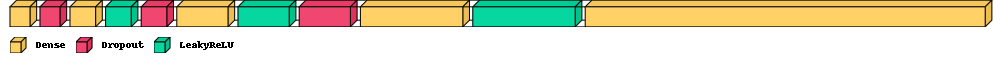

In [114]:
from PIL import ImageFont

import visualkeras
visualkeras.layered_view(autoencoder.encoder, legend=True) 


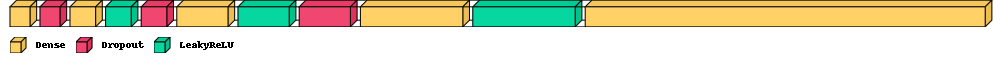

In [115]:
visualkeras.layered_view(autoencoder.decoder, legend=True) 

In [125]:
autoencoder.build((64, n_genes))

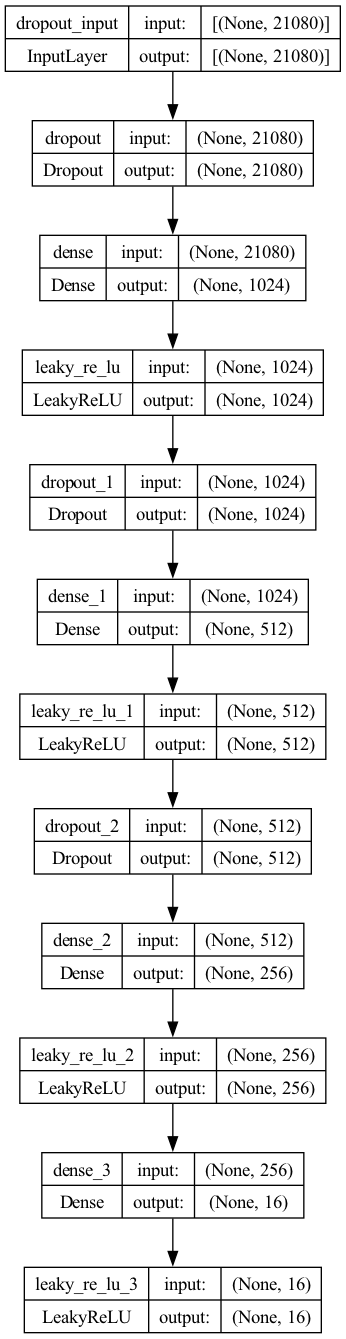

In [127]:
from keras.utils.vis_utils import plot_model
plot_model(autoencoder.encoder, show_shapes=True, show_layer_names=True)


In [155]:
hist = autoencoder.fit(x_train, epochs=100, callbacks=cb) # around 16 hours for transcripts dataset 

Epoch 1/100
36/36 [==============================] - 23s 580ms/step - loss: 0.0048 - lr: 1.0000e-05
Epoch 2/100
36/36 [==============================] - 21s 598ms/step - loss: 0.0048 - lr: 1.0000e-05
Epoch 3/100
36/36 [==============================] - 20s 569ms/step - loss: 0.0048 - lr: 1.0000e-05
Epoch 4/100
36/36 [==============================] - 21s 590ms/step - loss: 0.0048 - lr: 1.0000e-05
Epoch 5/100
36/36 [==============================] - 20s 554ms/step - loss: 0.0048 - lr: 1.0000e-05
Epoch 6/100
36/36 [==============================] - 20s 555ms/step - loss: 0.0048 - lr: 1.0000e-05
Epoch 7/100
36/36 [==============================] - 20s 560ms/step - loss: 0.0048 - lr: 1.0000e-05
Epoch 8/100
36/36 [==============================] - 23s 638ms/step - loss: 0.0048 - lr: 1.0000e-05
Epoch 9/100
36/36 [==============================] - 21s 601ms/step - loss: 0.0048 - lr: 1.0000e-05
Epoch 10/100
36/36 [==============================] - 22s 614ms/step - loss: 0.0048 - lr: 1.0000e-05

Keeping in mind that outputting a constant solution for every observation yields a loss value of ~0.2 for MT removed, log1p transformed dataset.

In [156]:
autoencoder.load_weights(checkpoint_filepath)


benchmarking model : vanilla_autoencoder
number of parametters of the model: 44494368
shape of the dataset: (2259, 21080)
the dataset meets the min_max requirement
loss: 0.004703208
adding new performer to the history


,model_name,param_count,loss,obs_count,gene_number
0,vanilla_autoencoder,44519040,2.109692,2259,21080
1,vanilla_autoencoder,44502592,0.008451,2259,21080
2,vanilla_autoencoder,44502592,0.006406,2259,21080
3,vanilla_autoencoder,44502592,0.004141,2259,21080
4,vanilla_autoencoder,44502592,0.003985,2259,21080
5,vanilla_autoencoder,44494368,0.009952,2259,21080
6,vanilla_autoencoder,44494368,0.007682,2259,21080
7,vanilla_autoencoder,44494368,0.005608,2259,21080
8,vanilla_autoencoder,44494368,0.004785,2259,21080
0,vanilla_autoencoder,44494368,0.004703,2259,21080


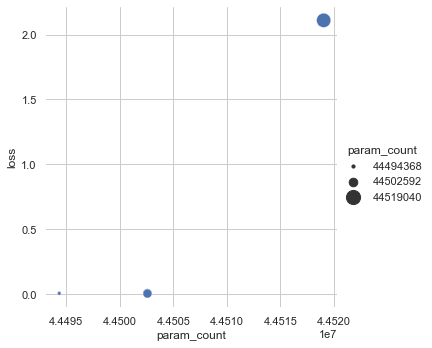

In [157]:
importlib.reload(benchmark) # to allow modification of the script without restarting the whole session
benchmark.benchmark(autoencoder, x_train)

[0.004798462148755789, 0.0047966716811060905, 0.004795008804649115, 0.004793418571352959, 0.0047919414937496185, 0.004790525883436203, 0.0047891102731227875, 0.0047876862809062, 0.0047864122316241264, 0.00478518707677722, 0.00478388462215662, 0.004782733507454395, 0.0047815581783652306, 0.004780336283147335, 0.004779167007654905, 0.004778104834258556, 0.004777103662490845, 0.0047759972512722015, 0.004774921108037233, 0.004773932974785566, 0.004772972781211138, 0.004771966952830553, 0.004770992789417505, 0.004769898485392332, 0.004769026301801205, 0.004768017213791609, 0.004767118953168392, 0.004766254220157862, 0.004765257705003023, 0.004764408338814974, 0.004763558506965637, 0.004762580618262291, 0.00476169865578413, 0.0047608958557248116, 0.004760015290230513, 0.004759049974381924, 0.004758174065500498, 0.004757298622280359, 0.004756477661430836, 0.0047555952332913876, 0.004754781723022461, 0.004753984976559877, 0.004753076005727053, 0.0047522312961518764, 0.0047512780874967575, 0.00

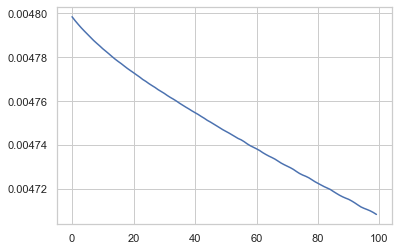

In [158]:
plt.plot(hist.history['loss'])
print(hist.history['loss'])




### some diagnosis

In [161]:
importlib.reload(visualisation) # to allow modification of the script without restarting the whole session
visualisation.plot_single_obs_processing(x_train, autoencoder)

In [162]:
compressed_dataframe = autoencoder.encoder.predict(x_train)

36/36 [==============================] - 1s 20ms/step


In [163]:
df = pd.DataFrame(compressed_dataframe)
df["name"] = filenames

71/71 [==============================] - 1s 12ms/step


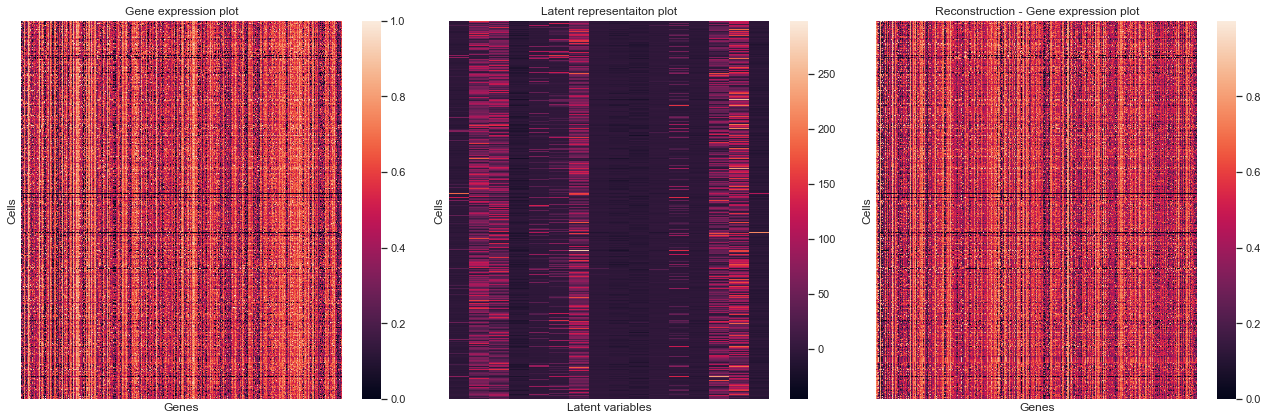

In [164]:
importlib.reload(visualisation) # to allow modification of the script without restarting the whole session
visualisation.plot_dataset_processing(x_train, autoencoder)

In [165]:
# Assuming clinical_info is a Pandas Series
unique_values = pd.Series(clinical_info).value_counts()

# If you want to create a DataFrame with columns for the value and its count
df = pd.DataFrame({'Value': unique_values.index, 'Count': unique_values.values})


# we want to keep the top n classes :
df_sorted = df.sort_values(by='Count', ascending=False)

# Get the top n types of cancer
top_n = df_sorted.iloc[:3]['Value'].tolist()

# Create a new list with 'other' for values not in the top n
new_clinical_info = ['other' if value not in top_n else value for value in clinical_info]

In [166]:
label = pd.Series(clinical_info)
label = pd.Series(new_clinical_info)


######################## OG Groups : 
######################## KNMEANS : 


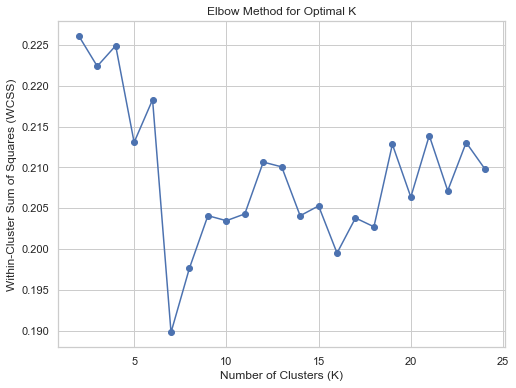

Silhouette Score: 0.2261
Dunn Index: 1.0000
Davies-Bouldin Index: 1.7426
######################## CONFUSION MATRIX : 


/opt/homebrew/anaconda3/envs/thesis/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.



Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "/opt/homebrew/anaconda3/envs/thesis/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3397, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/var/folders/xr/0fvz4r2s4wx1hx13jlhxj2z00000gn/T/ipykernel_79218/910968562.py", line 25, in <cell line: 25>
    visualisation.compare_cluser_vis(compressed_dataframe, label, str_kmeans_labels)
  File "/Users/aygalic/Thesis/genome_analysis_parkinson/thesis_related/../src/utils/visualisation.py", line 252, in compare_cluser_vis
    mapped_ground_truth = [label_mapping[label_1] for label in label_1]
  File "/Users/aygalic/Thesis/genome_analysis_parkinson/thesis_related/../src/utils/visualisation.py", line 252, in <listcomp>
    mapped_ground_truth = [label_mapping[label_1] for label in label_1]
TypeError: range indices must be integers or slices, not Series

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  Fil

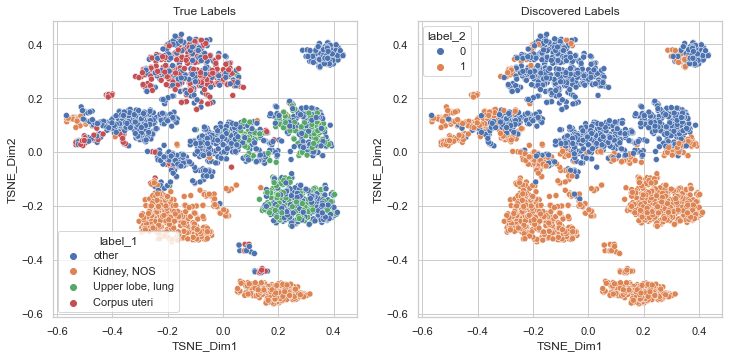

In [168]:
import helpers

importlib.reload(visualisation)
importlib.reload(helpers)

print("######################## OG Groups : ")
TSNE_params = {
            "early_exaggeration" : 50,
            "learning_rate" : 500, 
            "perplexity" : 75, 
            "min_grad_norm" : 1e-7, 
            "n_iter" : 2000,
            "n_components" : 2
        }
#visualisation.plot_clusters(compressed_dataframe, label, TSNE_params)
#benchmark.print_metrics(compressed_dataframe, label)

print("######################## KNMEANS : ")
kmeans_labels = helpers.auto_kMean(compressed_dataframe)
benchmark.print_metrics(compressed_dataframe, kmeans_labels)
#visualisation.plot_clusters(compressed_dataframe, kmeans_labels, TSNE_params)

print("######################## CONFUSION MATRIX : ")
str_kmeans_labels = [str(lab) for lab in kmeans_labels]
visualisation.compare_cluser_vis(compressed_dataframe, label, str_kmeans_labels)



In [73]:
source = [0, 0, 1, 1, 0]
target = [2, 3, 4, 5, 4]
value = [8, 2, 2, 8, 4]
link = dict(source = source, target = target, value = value)
link

{'source': [0, 0, 1, 1, 0],
 'target': [2, 3, 4, 5, 4],
 'value': [8, 2, 2, 8, 4]}

In [88]:
clustering_results = [str(l) for l in kmeans_labels]
# Create a DataFrame to count flow values
df = pd.DataFrame({'source': label, 'target': clustering_results})
flow_data = df.groupby(['source', 'target']).size().reset_index(name='value')

In [89]:
print(len(flow_data["source"].tolist()),
len(flow_data["target"].tolist()),
len(flow_data["value"].tolist()))


40 40 40


In [85]:
link = dict(source = flow_data["source"].tolist(), target = flow_data["target"].tolist(), value = flow_data["value"].tolist())

In [86]:
link

{'source': ['Corpus uteri',
  'Corpus uteri',
  'Corpus uteri',
  'Corpus uteri',
  'Corpus uteri',
  'Corpus uteri',
  'Corpus uteri',
  'Endometrium',
  'Endometrium',
  'Endometrium',
  'Endometrium',
  'Endometrium',
  'Endometrium',
  'Head of pancreas',
  'Head of pancreas',
  'Head of pancreas',
  'Head of pancreas',
  'Head of pancreas',
  'Kidney, NOS',
  'Kidney, NOS',
  'Kidney, NOS',
  'Kidney, NOS',
  'Kidney, NOS',
  'Kidney, NOS',
  'Kidney, NOS',
  'Kidney, NOS',
  'Upper lobe, lung',
  'Upper lobe, lung',
  'Upper lobe, lung',
  'Upper lobe, lung',
  'Upper lobe, lung',
  'other',
  'other',
  'other',
  'other',
  'other',
  'other',
  'other',
  'other',
  'other'],
 'target': ['0',
  '2',
  '3',
  '4',
  '5',
  '6',
  '7',
  '0',
  '2',
  '3',
  '4',
  '6',
  '7',
  '0',
  '1',
  '5',
  '7',
  '8',
  '0',
  '1',
  '2',
  '4',
  '5',
  '6',
  '7',
  '8',
  '0',
  '1',
  '2',
  '5',
  '7',
  '0',
  '1',
  '2',
  '3',
  '4',
  '5',
  '6',
  '7',
  '8'],
 'value': [64,


In [83]:
data = go.Sankey(link = link)


In [84]:
fig = go.Figure(data)

fig.show()

In [62]:
import plotly.graph_objects as go

fig = go.Figure(data=[go.Sankey(
    node = dict(
      pad = 15,
      thickness = 20,
      line = dict(color = "black", width = 0.5),
      label = ["A1", "A2", "B1", "B2", "C1", "C2"],
      color = "blue"
    ),
    link = dict(
      source = [0, 1, 0, 2, 3, 3], # indices correspond to labels, eg A1, A2, A1, B1, ...
      target = [2, 3, 3, 4, 4, 5],
      value = [8, 4, 2, 8, 4, 2]
  ))])

fig.update_layout(title_text="Basic Sankey Diagram", font_size=10)
fig.show()

AttributeError: 'Series' object has no attribute 'append'

In [ ]:
conf_matrix = confusion_matrix(label, kmeans_labels)

print(conf_matrix)

In [57]:
from sklearn.manifold import TSNE

True_labels = label.tolist()

#### TSNE

TSNE_params = {
    "early_exaggeration" : 50,
    "learning_rate" : 500, 
    "perplexity" : 15, 
    "min_grad_norm" : 1e-7, 
    "n_iter" : 5000,
    "n_components" : 2
}
tsne = TSNE(**TSNE_params).fit_transform(compressed_dataframe)
x_min, x_max = np.min(tsne, 0), np.max(tsne, 0)
tsne = tsne / (x_max - x_min)

TSNE_result = pd.DataFrame(tsne, columns=['TSNE_Dim1', 'TSNE_Dim2'])



######################## KNMEANS : 


C:\Users\Alain\AppData\Roaming\Python\Python39\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

C:\Users\Alain\AppData\Roaming\Python\Python39\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

C:\Users\Alain\AppData\Roaming\Python\Python39\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

C:\Users\Alain\AppData\Roaming\Python\Python39\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

C:\Users\Alain\AppData\Roaming\Python\Py

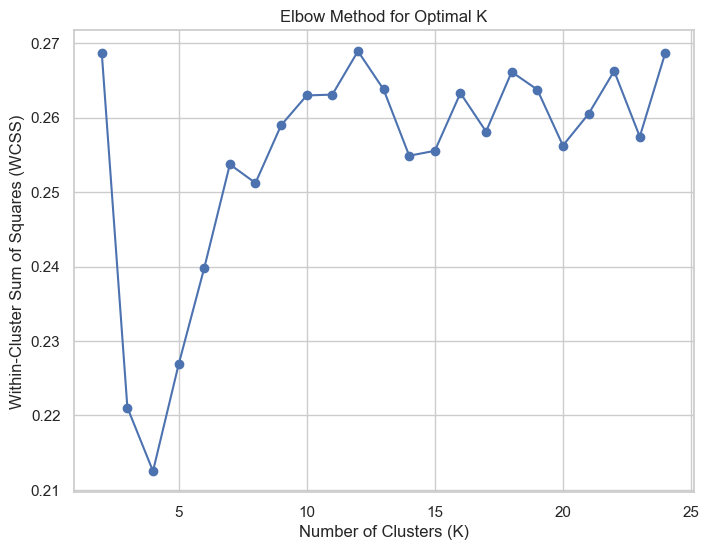

C:\Users\Alain\AppData\Roaming\Python\Python39\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

c:\thesis\genome_analysis_parkinson\genome_analysis_parkinson\thesis_related\../src\utils\visualisation.py:204: UserWarning:

No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored



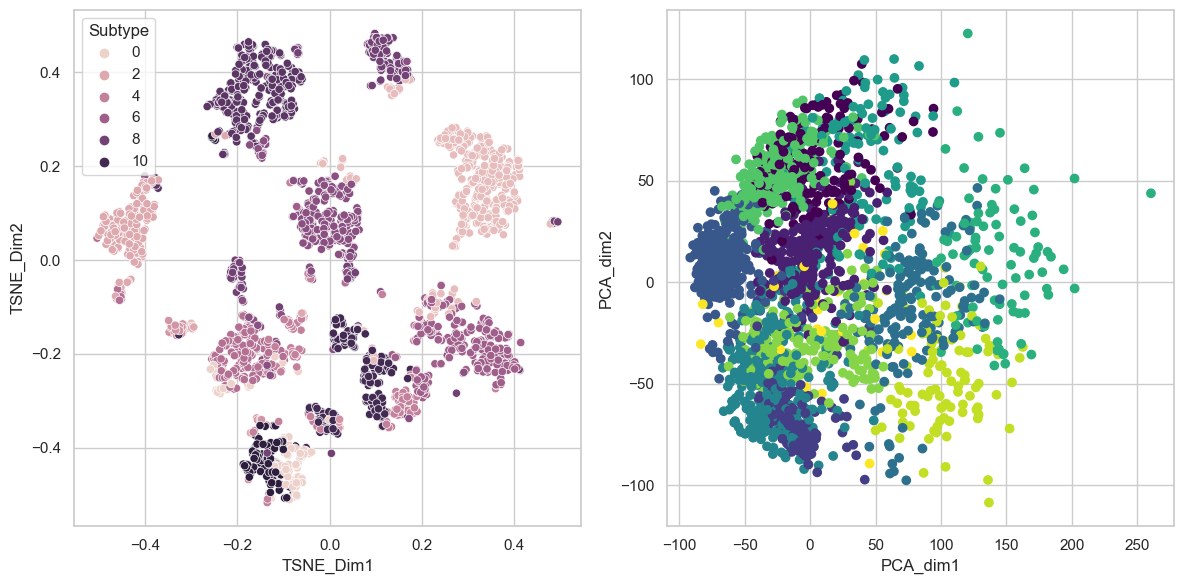

Silhouette Score: 0.2689
Dunn Index: 0.3188
Davies-Bouldin Index: 1.4490


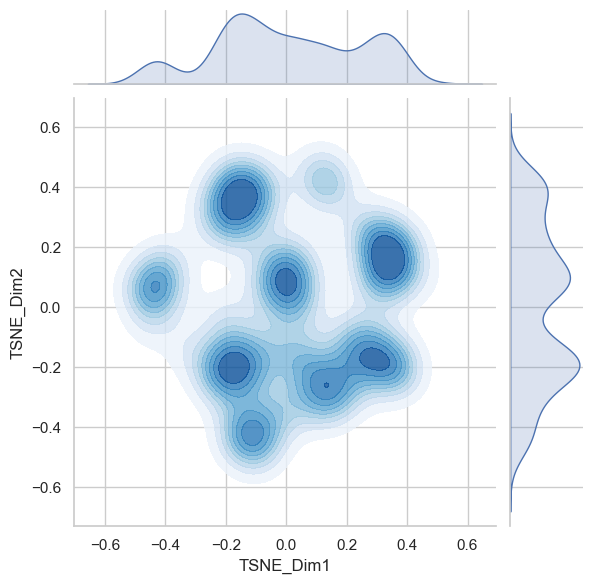

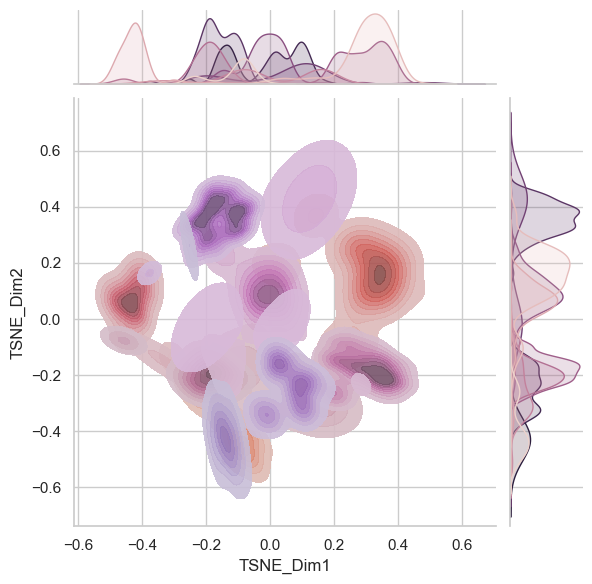

In [125]:
importlib.reload(helpers)
print("######################## KNMEANS : ")
kmeans_labels = helpers.auto_kMean(compressed_dataframe)
if(len(np.unique(kmeans_labels)) == 1):
    print("nothing found")
else:   
    visualisation.plot_clusters(compressed_dataframe, kmeans_labels, TSNE_params)
    benchmark.print_metrics(compressed_dataframe, kmeans_labels)
